# Load Data and Word-Embedding Models

In [1]:
import os
import re
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('NER_train.json', 'r'))
val_data = json.load(open('NER_val.json', 'r'))
test_data = json.load(open('NER_test.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [2]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

# LSTM Implementation

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.lstm = nn.LSTM(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize cell state
        out, (hn, cn) = self.lstm(x, (h0, c0))  # Forward propagate LSTM
        out = self.fc(out)
        return out

# Training and Validation Code

In [4]:
def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            #  Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"]
                pattern = r'[ ]+'
                text = re.split(pattern, text)
                labels = data["labels"]
                #  Convert text to embeddings
                embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                loss = criterion(outputs.view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Fine-Tuning on Validation Data

In [5]:
def fine_tune(model, embedding_model, val_data,  criterion, optimizer, device='cuda', epochs=3):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    model = model.to(device)
    model.train()
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        tuning_loss = 0
        actual = []
        predicted = []
        for _, data in val_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            actual.extend(targets.tolist())     
            tuning_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        tuning_loss = tuning_loss / len(val_data)
        accuracy = accuracy_score(actual, predicted)
        f1 = f1_score(actual, predicted, average="macro")
        print(f"FineTuning: Loss: {tuning_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        

# Testing Code

In [6]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    
    if show_labelwise:
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(test_actual[i])
            labelwise_predictions[test_actual[i]]["predicted"].append(test_predicted[i])
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            import matplotlib.pyplot as plt
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [7]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [8]:
input_size = 300  # Embedding size
hidden_size = 128  # 128 Hidden size of the RNN
output_size = 27   # BIO encoding

# For Word2Vec Embeddings

In [9]:
lstm_word2vec_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_word2vec_model.parameters(), lr=0.001)
# optimizer = optim.SGD(lstm_word2vec_model.parameters(), lr=0.1)   #momentum=0.9, 0.6, 0.1, 0.0

In [10]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            lstm_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.4565, Accuracy: 0.8900, F1: 0.3096
Validation: Loss: 0.3375, Accuracy: 0.9110, F1: 0.3764
Epoch 2/10
Training: Loss: 0.3061, Accuracy: 0.9170, F1: 0.4484
Validation: Loss: 0.3045, Accuracy: 0.9194, F1: 0.4569
Epoch 3/10
Training: Loss: 0.2652, Accuracy: 0.9260, F1: 0.5279
Validation: Loss: 0.2902, Accuracy: 0.9217, F1: 0.5108
Epoch 4/10
Training: Loss: 0.2351, Accuracy: 0.9331, F1: 0.5928
Validation: Loss: 0.2861, Accuracy: 0.9234, F1: 0.5335
Epoch 5/10
Training: Loss: 0.2115, Accuracy: 0.9387, F1: 0.6403
Validation: Loss: 0.2894, Accuracy: 0.9247, F1: 0.5377
Epoch 6/10
Training: Loss: 0.1897, Accuracy: 0.9439, F1: 0.6741
Validation: Loss: 0.2961, Accuracy: 0.9250, F1: 0.5481
Epoch 7/10
Training: Loss: 0.1702, Accuracy: 0.9490, F1: 0.7066
Validation: Loss: 0.3123, Accuracy: 0.9247, F1: 0.5445
Epoch 8/10
Training: Loss: 0.1536, Accuracy: 0.9535, F1: 0.7352
Validation: Loss: 0.3278, Accuracy: 0.9229, F1: 0.5395
Epoch 9/10
Training: Loss: 0.1400, Accuracy: 0.9

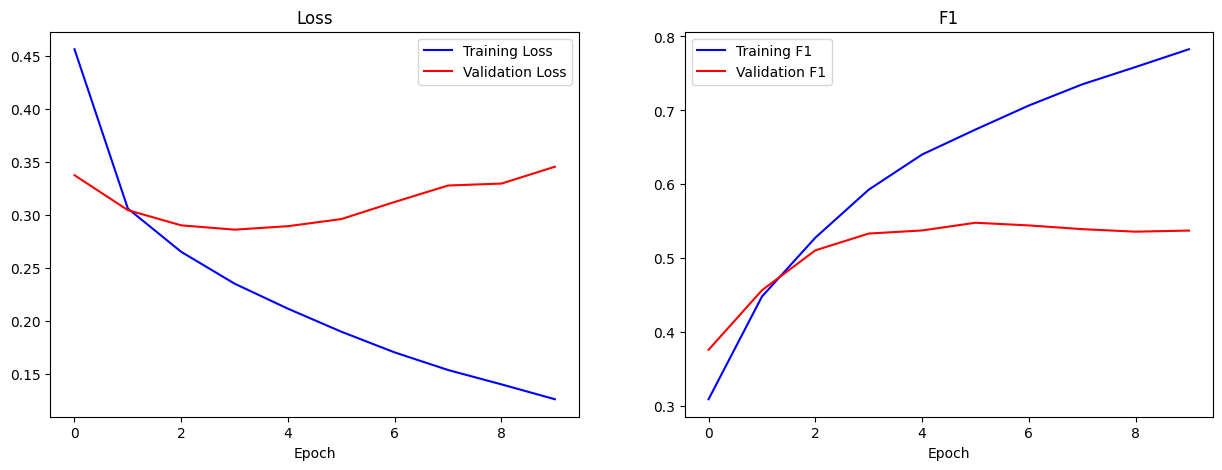

In [11]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [12]:
# fine_tune(lstm_word2vec_model, word2vec, val_data, criterion, optimizer, device='cuda', epochs=2)

In [13]:
test_accuracy, test_f1 = test("t1_model2_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.036595510624954364, 1: 0.05095541401273886, 2: 0.06380789022298455, 3: 0.026373626373626374, 4: 0.03152709359605912, 5: 0.0422740524781341, 6: 0.04515050167224081, 7: 0.13114754098360656, 8: 0.12041432887354338, 9: 0.22955974842767296, 10: 0.1773248407643312, 11: 0.10598705501618123, 12: 0.08541300527240774, 13: 0.10040160642570282, 14: 0.04360012457178449, 15: 0.051491365777080064, 16: 0.17632241813602015, 17: 0.15384615384615383, 18: 0.1411764705882353, 19: 0.10548523206751054, 20: 0.05355884425651868, 21: 0.08333333333333334, 22: 0.039999999999999994, 23: 0.14232209737827714, 24: 0.2222222222222222, 25: 0.15, 26: 0.06779661016949153}
Labelwise Accuracy Scores:
{0: 0.9764384559359067, 1: 0.2975206611570248, 2: 0.5406976744186046, 3: 0.22641509433962265, 4: 0.3096774193548387, 5: 0.42028985507246375, 6: 0.4153846153846154, 7: 0.6486486486486487, 8: 0.7284595300261096, 9: 0.8488372093023255, 10: 0.7963386727688787, 11: 0.7359550561797753, 12: 0.74539877300613

In [14]:
lstm_word2vec_model = lstm_word2vec_model.to('cpu')
torch.save(lstm_word2vec_model, "t1_model2_word2vec.pt")

In [15]:
test_accuracy, test_f1 = test("t1_model2_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.03802811315516626, 1: 0.049689440993788817, 2: 0.08742911153119093, 3: 0.03857868020304569, 4: 0.03909465020576132, 5: 0.0479570305006714, 6: 0.05420991926182237, 7: 0.10200000000000001, 8: 0.09148318825738182, 9: 0.17806451612903224, 10: 0.14390983961855222, 11: 0.10645161290322581, 12: 0.08601398601398601, 13: 0.10852713178294575, 14: 0.043599493029150824, 15: 0.05167777818704188, 16: 0.22040302267002518, 17: 0.1, 18: 0.125, 19: 0.09285714285714286, 20: 0.058365758754863814, 21: 0.28571428571428575, 22: 0.0909090909090909, 23: 0.155688622754491, 24: 0.1, 25: 0.0625, 26: 0.0541871921182266}
Labelwise Accuracy Scores:
{0: 0.9777130371449381, 1: 0.3305785123966942, 2: 0.5377906976744186, 3: 0.2389937106918239, 4: 0.3064516129032258, 5: 0.4528985507246377, 6: 0.48205128205128206, 7: 0.6891891891891891, 8: 0.6997389033942559, 9: 0.8023255813953488, 10: 0.7597254004576659, 11: 0.7415730337078652, 12: 0.754601226993865, 13: 0.4827586206896552, 14: 0.48587570621468

# For GloVe Embeddings

In [16]:
input_size, hidden_size, output_size = 300, 128, 27

lstm_glove_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(lstm_glove_model.parameters(), lr=0.001)
optimizer = optim.SGD(lstm_glove_model.parameters(), lr=0.1)   #momentum=0.9, 0.6, 0.1, 0.0

In [17]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            lstm_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.5780, Accuracy: 0.8644, F1: 0.1434
Validation: Loss: 0.4910, Accuracy: 0.8796, F1: 0.2245
Epoch 2/10
Training: Loss: 0.4619, Accuracy: 0.8833, F1: 0.2470
Validation: Loss: 0.4511, Accuracy: 0.8872, F1: 0.2917
Epoch 3/10
Training: Loss: 0.4283, Accuracy: 0.8903, F1: 0.3034
Validation: Loss: 0.4359, Accuracy: 0.8899, F1: 0.3252
Epoch 4/10
Training: Loss: 0.4099, Accuracy: 0.8938, F1: 0.3415
Validation: Loss: 0.4292, Accuracy: 0.8905, F1: 0.3387
Epoch 5/10
Training: Loss: 0.3964, Accuracy: 0.8964, F1: 0.3644
Validation: Loss: 0.4260, Accuracy: 0.8907, F1: 0.3510
Epoch 6/10
Training: Loss: 0.3850, Accuracy: 0.8988, F1: 0.3836
Validation: Loss: 0.4247, Accuracy: 0.8902, F1: 0.3592
Epoch 7/10
Training: Loss: 0.3752, Accuracy: 0.9008, F1: 0.3995
Validation: Loss: 0.4246, Accuracy: 0.8907, F1: 0.3668
Epoch 8/10
Training: Loss: 0.3657, Accuracy: 0.9029, F1: 0.4128
Validation: Loss: 0.4260, Accuracy: 0.8907, F1: 0.3729
Epoch 9/10
Training: Loss: 0.3570, Accuracy: 0.9

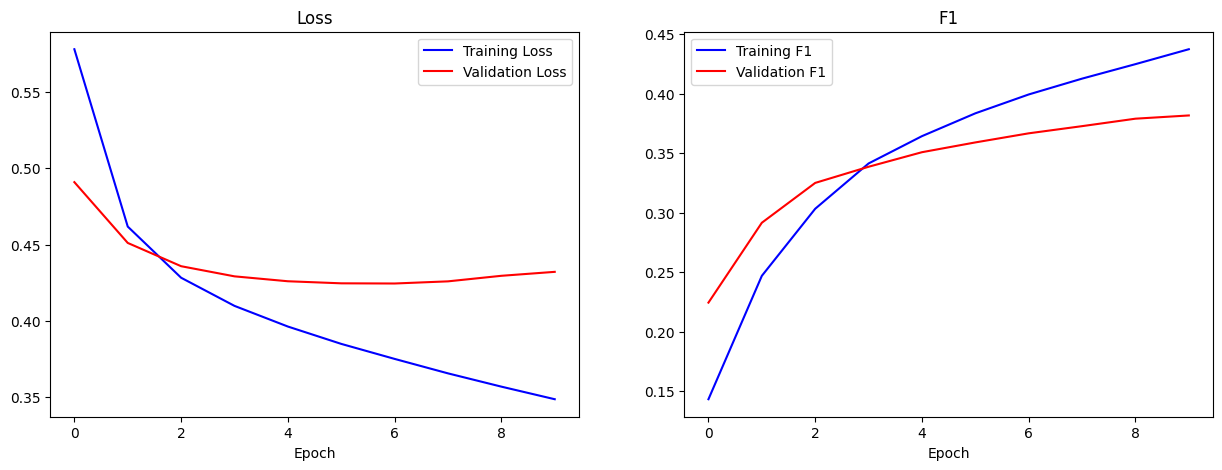

In [18]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [19]:
# fine_tune(lstm_glove_model, glove, val_data, criterion, optimizer, device='cuda', epochs=2)

In [20]:
test_accuracy, test_f1 = test(lstm_glove_model, glove, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.041029646473049505, 1: 0.027586206896551724, 2: 0.05577047066408769, 3: 0.0, 4: 0.019467401285583105, 5: 0.02319526627218935, 6: 0.047520661157024795, 7: 0.09277620396600567, 8: 0.07022144522144522, 9: 0.06936708860759494, 10: 0.07259475218658892, 11: 0.04107142857142858, 12: 0.062156448202959826, 13: 0.04848484848484848, 14: 0.04886363636363636, 15: 0.053337067861715756, 16: 0.08927680798004987, 17: 0.06666666666666667, 18: 0.03333333333333334, 19: 0.1801801801801802, 20: 0.044354838709677415, 21: 0.0, 22: 0.0909090909090909, 23: 0.15151515151515152, 24: 0.0, 25: 0.0, 26: 0.005208333333333334}
Labelwise Accuracy Scores:
{0: 0.9698834668608886, 1: 0.19834710743801653, 2: 0.502906976744186, 3: 0.0, 4: 0.17096774193548386, 5: 0.17753623188405798, 6: 0.35384615384615387, 7: 0.5900900900900901, 8: 0.6292428198433421, 9: 0.5310077519379846, 10: 0.5697940503432495, 11: 0.25842696629213485, 12: 0.450920245398773, 13: 0.13793103448275862, 14: 0.24293785310734464, 15:

In [21]:
lstm_glove_model = lstm_glove_model.to('cpu')
torch.save(lstm_glove_model, "t1_model2_glove.pt")

In [22]:
test_accuracy, test_f1 = test("t1_model2_glove.pt", glove, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.041029646473049505, 1: 0.027586206896551724, 2: 0.05577047066408769, 3: 0.0, 4: 0.019467401285583105, 5: 0.02319526627218935, 6: 0.047520661157024795, 7: 0.09277620396600567, 8: 0.07022144522144522, 9: 0.06936708860759494, 10: 0.07259475218658892, 11: 0.04107142857142858, 12: 0.062156448202959826, 13: 0.04848484848484848, 14: 0.04886363636363636, 15: 0.053337067861715756, 16: 0.08927680798004987, 17: 0.06666666666666667, 18: 0.03333333333333334, 19: 0.1801801801801802, 20: 0.044354838709677415, 21: 0.0, 22: 0.0909090909090909, 23: 0.15151515151515152, 24: 0.0, 25: 0.0, 26: 0.005208333333333334}
Labelwise Accuracy Scores:
{0: 0.9698834668608886, 1: 0.19834710743801653, 2: 0.502906976744186, 3: 0.0, 4: 0.17096774193548386, 5: 0.17753623188405798, 6: 0.35384615384615387, 7: 0.5900900900900901, 8: 0.6292428198433421, 9: 0.5310077519379846, 10: 0.5697940503432495, 11: 0.25842696629213485, 12: 0.450920245398773, 13: 0.13793103448275862, 14: 0.24293785310734464, 15:

# For FastText Embeddings

In [23]:
input_size, hidden_size, output_size = 300, 128, 27
lstm_fasttext_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_fasttext_model.parameters(), lr=0.001)
optimizer = optim.SGD(lstm_fasttext_model.parameters(), lr=0.1, momentum=0.1)   #momentum=0.9, 0.6, 0.1, 0.0

In [24]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        lstm_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.6404, Accuracy: 0.8550, F1: 0.0762
Validation: Loss: 0.5084, Accuracy: 0.8765, F1: 0.1543
Epoch 2/10
Training: Loss: 0.4416, Accuracy: 0.8872, F1: 0.2626
Validation: Loss: 0.3930, Accuracy: 0.9004, F1: 0.3192
Epoch 3/10
Training: Loss: 0.3636, Accuracy: 0.9050, F1: 0.3578
Validation: Loss: 0.3429, Accuracy: 0.9119, F1: 0.3736
Epoch 4/10
Training: Loss: 0.3280, Accuracy: 0.9121, F1: 0.3914
Validation: Loss: 0.3156, Accuracy: 0.9169, F1: 0.3972
Epoch 5/10
Training: Loss: 0.3049, Accuracy: 0.9169, F1: 0.4158
Validation: Loss: 0.3014, Accuracy: 0.9199, F1: 0.4148
Epoch 6/10
Training: Loss: 0.2909, Accuracy: 0.9199, F1: 0.4347
Validation: Loss: 0.2938, Accuracy: 0.9215, F1: 0.4268
Epoch 7/10
Training: Loss: 0.2775, Accuracy: 0.9225, F1: 0.4512
Validation: Loss: 0.2850, Accuracy: 0.9223, F1: 0.4423
Epoch 8/10
Training: Loss: 0.2658, Accuracy: 0.9248, F1: 0.4707
Validation: Loss: 0.2814, Accuracy: 0.9238, F1: 0.4580
Epoch 9/10
Training: Loss: 0.2595, Accuracy: 0.9

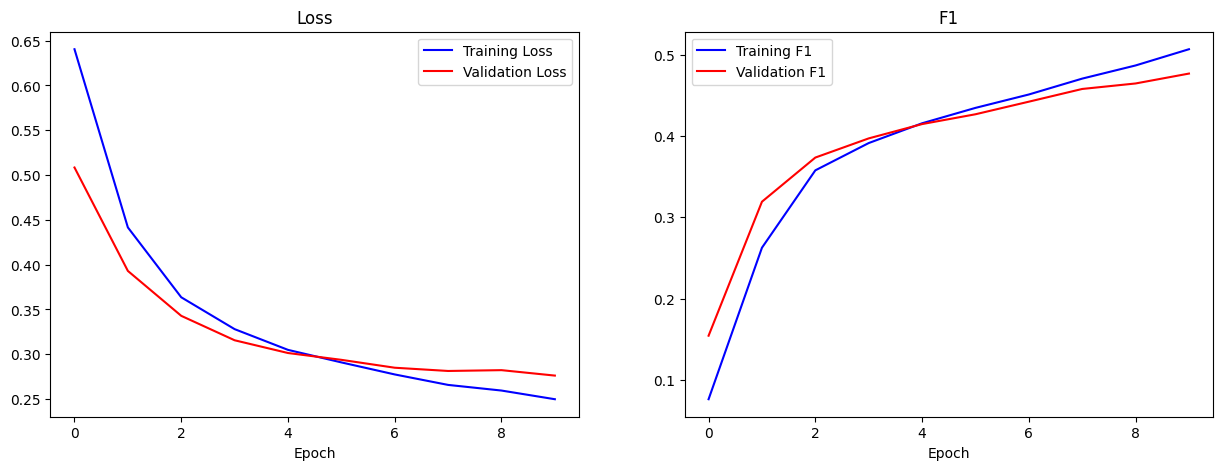

In [25]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [26]:
# fine_tune(lstm_fasttext_model, fasttext, val_data, criterion, optimizer, device='cuda', epochs=2)

In [27]:
test_accuracy, test_f1 = test(lstm_fasttext_model, fasttext, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.04130392192876122, 1: 0.03866666666666667, 2: 0.1185617103984451, 3: 0.007653061224489797, 4: 0.044611528822055144, 5: 0.055286521388216305, 6: 0.1, 7: 0.08441961514587212, 8: 0.09500083042683939, 9: 0.18273684210526314, 10: 0.1484771573604061, 11: 0.10215946843853821, 12: 0.07205387205387205, 13: 0.04307692307692308, 14: 0.04705882352941177, 15: 0.06366892160764027, 16: 0.30303030303030304, 17: 0.1212121212121212, 18: 0.0, 19: 0.006060606060606061, 20: 0.03222222222222222, 21: 0.0, 22: 0.049999999999999996, 23: 0.1841269841269841, 24: 0.04444444444444444, 25: 0.0625, 26: 0.0632183908045977}
Labelwise Accuracy Scores:
{0: 0.9827385287691187, 1: 0.2396694214876033, 2: 0.7093023255813954, 3: 0.05660377358490566, 4: 0.2870967741935484, 5: 0.4963768115942029, 6: 0.6666666666666666, 7: 0.6126126126126126, 8: 0.7467362924281984, 9: 0.8410852713178295, 10: 0.8032036613272311, 11: 0.6910112359550562, 12: 0.656441717791411, 13: 0.1206896551724138, 14: 0.44067796610169

In [28]:
lstm_fasttext_model = lstm_fasttext_model.to('cpu')
torch.save(lstm_fasttext_model, "t1_model2_fasttext.pt")

In [29]:
test_accuracy, test_f1 = test("t1_model2_fasttext.pt", fasttext, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.04130392192876122, 1: 0.03866666666666667, 2: 0.1185617103984451, 3: 0.007653061224489797, 4: 0.044611528822055144, 5: 0.055286521388216305, 6: 0.1, 7: 0.08441961514587212, 8: 0.09500083042683939, 9: 0.18273684210526314, 10: 0.1484771573604061, 11: 0.10215946843853821, 12: 0.07205387205387205, 13: 0.04307692307692308, 14: 0.04705882352941177, 15: 0.06366892160764027, 16: 0.30303030303030304, 17: 0.1212121212121212, 18: 0.0, 19: 0.006060606060606061, 20: 0.03222222222222222, 21: 0.0, 22: 0.049999999999999996, 23: 0.1841269841269841, 24: 0.04444444444444444, 25: 0.0625, 26: 0.0632183908045977}
Labelwise Accuracy Scores:
{0: 0.9827385287691187, 1: 0.2396694214876033, 2: 0.7093023255813954, 3: 0.05660377358490566, 4: 0.2870967741935484, 5: 0.4963768115942029, 6: 0.6666666666666666, 7: 0.6126126126126126, 8: 0.7467362924281984, 9: 0.8410852713178295, 10: 0.8032036613272311, 11: 0.6910112359550562, 12: 0.656441717791411, 13: 0.1206896551724138, 14: 0.44067796610169